<a href="https://colab.research.google.com/github/m5281004/anomaly_derection/blob/main/%E4%B8%BB%E3%82%B3%E3%83%BC%E3%83%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/地熱')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/地熱


In [ ]:
##
## ---- ライブラリ
##

import warnings
warnings.simplefilter('ignore', DeprecationWarning)

import numpy as np
import pandas as pd
# 表示する行列サイズを無制限に
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 作図関係
import matplotlib.pyplot as plt
!pip install japanize-matplotlib
import japanize_matplotlib

# 機械学習関係
from sklearn.ensemble import IsolationForest # 決定木を仕組みを利用した異常検知
from sklearn.neighbors import LocalOutlierFactor  # LOF はあるデータの集まりの中から外れ値を見つけ出す外れ値検知アルゴリズム

# torch関係
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

# 自作関数
from autoencorder import Autoencoder, AE_T2RE
from mspc import mspc_CL, mspc_ref, mspc_T2Q, cont_T2Q
from scale import autoscale, scaling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
##
## ------------------------ 6.5 データの読み込み ------------------------
##

# 正常データの読み込み
global train_data

file = "P1-14T_S03.csv"

print("================train_dataを読みます=======================\n")

train_data = pd.read_csv('by_segment/' + file )
print("train_dataの行列サイズは、", train_data.shape, "\n")
print("train_dataの変数名は、")
[i for i in enumerate(train_data.columns) ]

================train_dataを読みます=======================

train_dataの行列サイズは、 (100, 35) 

train_dataの変数名は、


[(0, 'dt'),
 (1, '外注測定_熱水Al'),
 (2, '外注測定_熱水B'),
 (3, '外注測定_熱水Ca'),
 (4, '外注測定_熱水Cl'),
 (5, '外注測定_熱水EC'),
 (6, '外注測定_熱水Fe'),
 (7, '外注測定_熱水K'),
 (8, '外注測定_熱水Mg'),
 (9, '外注測定_熱水Na'),
 (10, '外注測定_熱水SO4'),
 (11, '外注測定_熱水SiO2'),
 (12, '外注測定_熱水pH'),
 (13, '外注測定_蒸気CO2(wt%)'),
 (14, '外注測定_蒸気H2S(wt%)'),
 (15, '外注測定_蒸気NCG(wt%)'),
 (16, '外注測定_蒸気R(wt%)'),
 (17, '外注測定_蒸気凝縮水Cl'),
 (18, '外注測定_蒸気凝縮水EC'),
 (19, '外注測定_蒸気凝縮水SO4'),
 (20, '外注測定_蒸気凝縮水pH'),
 (21, '自社測定_熱水Ca'),
 (22, '自社測定_熱水Cl'),
 (23, '自社測定_熱水EC'),
 (24, '自社測定_熱水Fe'),
 (25, '自社測定_熱水K'),
 (26, '自社測定_熱水Mn'),
 (27, '自社測定_熱水Na'),
 (28, '自社測定_熱水SO4'),
 (29, '自社測定_熱水SiO2'),
 (30, '自社測定_熱水pH'),
 (31, '自社測定_熱水濁度'),
 (32, '自社測定_蒸気NCG(wt%)'),
 (33, '自社測定_蒸気温度'),
 (34, '自社測定_蒸気過熱度')]

In [ ]:

# train_dataから、stdがある程度大きく、使用する変数だけ残す：

print("================使用できる変数だけ残し、dfをつくります=======================\n")
std_threshold = 1e-04
vars_to_retain = train_data.describe().T.loc[train_data.describe().T["std"]>std_threshold, : ].index.to_list()
print("標準偏差stdが", std_threshold, "より大きい変数は\n")
for i in range(len(vars_to_retain)):
  print(i, vars_to_retain[i])

print("\nの ", len(vars_to_retain), " 個で、\n")

print("============train_data から、これらの変数だけ残して df に代入すると、：==========\n")

df = train_data[vars_to_retain]
print(df.shape, "になりました：\n")

print("dfの最初の５行は、\n")
df.head()

# 異常データもおなじように読み込む必要があるが、明らかな異常データが入手しづらいので、以降では正常データのみで処理を行う
# faulty_data = pd.read_csv('test_faulty.csv')


================使用できる変数だけ残し、dfをつくります=======================

標準偏差stdが 0.0001 より大きい変数は

0 外注測定_熱水Al
1 外注測定_熱水B
2 外注測定_熱水Ca
3 外注測定_熱水Cl
4 外注測定_熱水EC
5 外注測定_熱水Fe
6 外注測定_熱水K
7 外注測定_熱水Mg
8 外注測定_熱水Na
9 外注測定_熱水SO4
10 外注測定_熱水SiO2
11 外注測定_熱水pH
12 外注測定_蒸気CO2(wt%)
13 外注測定_蒸気H2S(wt%)
14 外注測定_蒸気NCG(wt%)
15 外注測定_蒸気R(wt%)
16 外注測定_蒸気凝縮水Cl
17 外注測定_蒸気凝縮水EC
18 外注測定_蒸気凝縮水SO4
19 外注測定_蒸気凝縮水pH
20 自社測定_熱水Ca
21 自社測定_熱水Cl
22 自社測定_熱水EC
23 自社測定_熱水Fe
24 自社測定_熱水K
25 自社測定_熱水Mn
26 自社測定_熱水Na
27 自社測定_熱水SiO2
28 自社測定_熱水pH
29 自社測定_蒸気NCG(wt%)

の  30  個で、

============train_data から、これらの変数だけ残して df に代入すると、：==========

(100, 30) になりました：

dfの最初の５行は、



,外注測定_熱水Al,外注測定_熱水B,外注測定_熱水Ca,外注測定_熱水Cl,外注測定_熱水EC,外注測定_熱水Fe,外注測定_熱水K,外注測定_熱水Mg,外注測定_熱水Na,外注測定_熱水SO4,外注測定_熱水SiO2,外注測定_熱水pH,外注測定_蒸気CO2(wt%),外注測定_蒸気H2S(wt%),外注測定_蒸気NCG(wt%),外注測定_蒸気R(wt%),外注測定_蒸気凝縮水Cl,外注測定_蒸気凝縮水EC,外注測定_蒸気凝縮水SO4,外注測定_蒸気凝縮水pH,自社測定_熱水Ca,自社測定_熱水Cl,自社測定_熱水EC,自社測定_熱水Fe,自社測定_熱水K,自社測定_熱水Mn,自社測定_熱水Na,自社測定_熱水SiO2,自社測定_熱水pH,自社測定_蒸気NCG(wt%)
0,0.03,184.8750,379.093750,8655.468750,23.642187,5.34,780.234375,3.354219,4727.656250,64.892188,525.734375,6.743750,98.235938,1.235937,4.419704,0.528125,0.14,51.1,0.17,4.3,189.598214,7669.196429,22.516071,2.065179,688.776786,12.283929,4194.553571,463.607143,6.899375,4.577496
1,0.03,184.5625,377.453125,8622.265625,23.528906,5.34,782.382812,3.242891,4706.171875,64.403906,526.632812,6.728125,98.232031,1.232031,4.397125,0.535937,0.14,51.1,0.17,4.3,190.200893,7690.401786,22.591964,2.067411,694.111607,12.458036,4207.723214,466.196429,6.885313,4.563122
2,0.03,184.2500,375.812500,8589.062500,23.415625,5.34,784.531250,3.131562,4684.687500,63.915625,527.531250,6.712500,98.228125,1.228125,4.374546,0.543750,0.14,51.1,0.17,4.3,190.803571,7711.607143,22.667857,2.069643,699.446429,12.632143,4220.892857,468.785714,6.871250,4.548747
3,0.03,183.9375,374.171875,8555.859375,23.302344,5.34,786.679688,3.020234,4663.203125,63.427344,528.429688,6.696875,98.224219,1.224219,4.351967,0.551562,0.14,51.1,0.17,4.3,191.406250,7732.812500,22.743750,2.071875,704.781250,12.806250,4234.062500,471.375000,6.857187,4.534373
4,0.03,183.6250,372.531250,8522.656250,23.189062,5.34,788.828125,2.908906,4641.718750,62.939062,529.328125,6.681250,98.220313,1.220312,4.329388,0.559375,0.14,51.1,0.17,4.3,192.008929,7754.017857,22.819643,2.074107,710.116071,12.980357,4247.232143,473.964286,6.843125,4.519998


In [ ]:

# df を標準化

print("================dfを標準化します=======================\n")

df_scaled, meanX, stdX = autoscale(df) # autoscale()は Xscale, meanX, stdX を返す
print("\n標準化後のdfの、最初の５行は、\n")
df_scaled.round(2).head()

================dfを標準化します=======================


標準化後のdfの、最初の５行は、



,外注測定_熱水Al,外注測定_熱水B,外注測定_熱水Ca,外注測定_熱水Cl,外注測定_熱水EC,外注測定_熱水Fe,外注測定_熱水K,外注測定_熱水Mg,外注測定_熱水Na,外注測定_熱水SO4,外注測定_熱水SiO2,外注測定_熱水pH,外注測定_蒸気CO2(wt%),外注測定_蒸気H2S(wt%),外注測定_蒸気NCG(wt%),外注測定_蒸気R(wt%),外注測定_蒸気凝縮水Cl,外注測定_蒸気凝縮水EC,外注測定_蒸気凝縮水SO4,外注測定_蒸気凝縮水pH,自社測定_熱水Ca,自社測定_熱水Cl,自社測定_熱水EC,自社測定_熱水Fe,自社測定_熱水K,自社測定_熱水Mn,自社測定_熱水Na,自社測定_熱水SiO2,自社測定_熱水pH,自社測定_蒸気NCG(wt%)
0,-0.81,-0.42,-0.55,0.16,-0.01,1.15,0.31,-0.37,-0.06,0.83,0.51,-0.23,-0.09,0.20,1.02,-0.60,0.4,0.4,-0.4,0.33,-0.37,0.25,0.21,-0.76,0.17,-0.55,-0.42,0.10,0.22,0.78
1,-0.81,-0.46,-0.72,0.09,-0.11,1.15,0.33,-0.50,-0.15,0.74,0.54,-0.29,-0.11,0.17,0.97,-0.35,0.4,0.4,-0.4,0.33,-0.36,0.28,0.25,-0.76,0.22,-0.50,-0.39,0.13,0.16,0.75
2,-0.81,-0.50,-0.89,0.01,-0.20,1.15,0.36,-0.63,-0.24,0.65,0.56,-0.34,-0.13,0.15,0.93,-0.09,0.4,0.4,-0.4,0.33,-0.35,0.31,0.28,-0.75,0.28,-0.45,-0.36,0.15,0.10,0.72
3,-0.81,-0.53,-1.07,-0.06,-0.29,1.15,0.38,-0.76,-0.33,0.56,0.59,-0.39,-0.15,0.13,0.88,0.16,0.4,0.4,-0.4,0.33,-0.34,0.34,0.31,-0.75,0.34,-0.40,-0.33,0.18,0.04,0.70
4,-0.81,-0.57,-1.24,-0.14,-0.39,1.15,0.41,-0.90,-0.42,0.47,0.61,-0.44,-0.17,0.11,0.84,0.41,0.4,0.4,-0.4,0.33,-0.33,0.37,0.35,-0.74,0.39,-0.35,-0.30,0.21,-0.02,0.67


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


ＬＯＦの管理限界は： -1.3409 



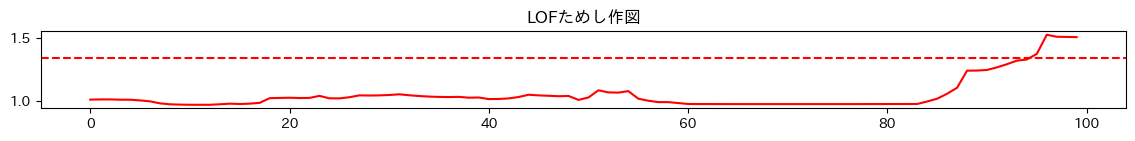

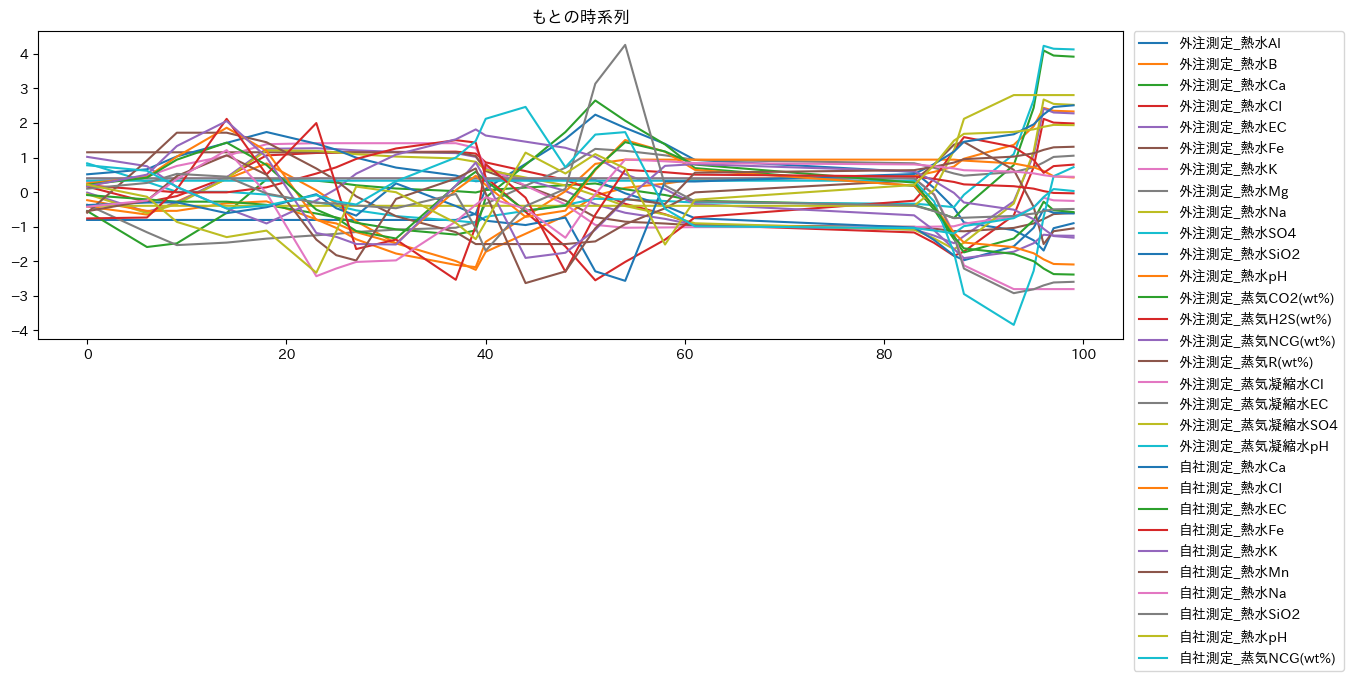

In [ ]:
##
## ------------------------ 6.6 LOFでの異常検知------------------------
##

# 正常データを用いたモデルの学習
model_LOF = LocalOutlierFactor(n_neighbors = 50, novelty = True, contamination = 0.05)
# novelty: 未知のデータに対して適用する場合True。n_neiborsとcontaminationはそれぞれ調整する必要
# contamination: 外れ値の割合を表す引数
# n_neighbors:  近傍オブジェクト数

model_LOF.fit(df_scaled)
# 入力にNaNがあるとダメっぽい  datetime型かobject型のままやるとfloatに変換できないエラー出る

# LOFスコアの計算
score_lof = model_LOF.score_samples(df_scaled) # 管理限界（負の値）より小さい場合に異常と判定

# LOF管理限界の取得
CL_lof = model_LOF.offset_
print("ＬＯＦの管理限界は：", round(CL_lof, 4), "\n")

# ためし図示
plt.figure(figsize=(14,1))
plt.plot(range(0, len(score_lof)), abs(score_lof), color = "r") # 求めたLOFスコア
plt.axhline( y=abs(CL_lof), color = "r", linestyle = 'dashed') # 管理限界score_lof(点線) ※絶対値に直したので、点線を上回ったところが異常判定
plt.title("LOFためし作図")

df_scaled.plot(figsize=(14,4))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title("もとの時系列")

plt.show() # 異常個所が、各変数があばれている個所とだいたい一致しているもよう。

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


iForestの管理限界は：  -0.5948 



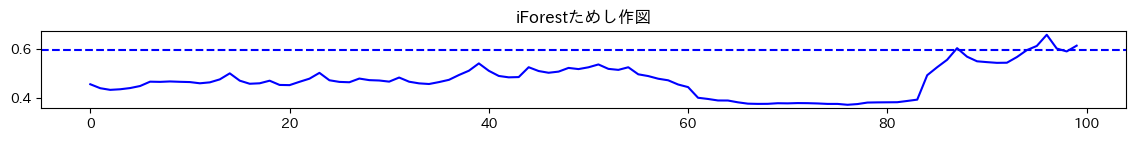

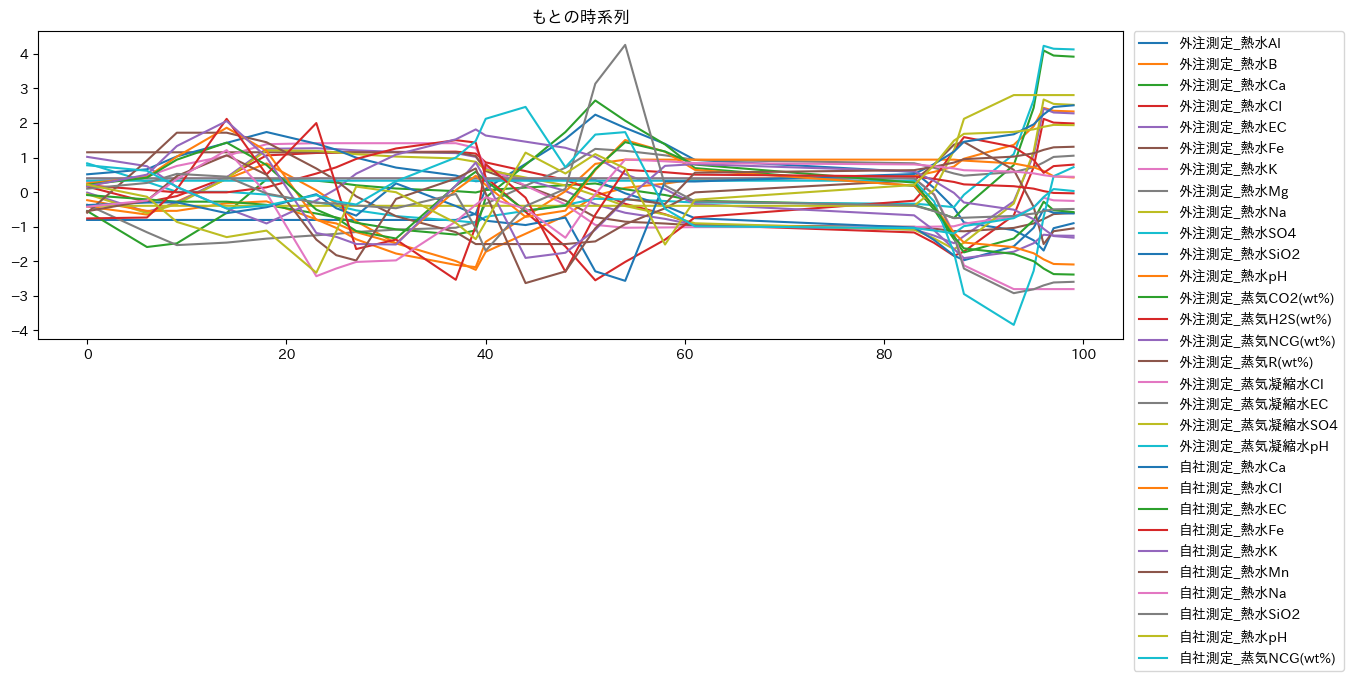

In [ ]:
##
## ------------------------ 6.7 iForestでの異常検知 ------------------------
##

# 正常データを用いたモデルの学習
model_IFOREST = IsolationForest(contamination = 0.05)
model_IFOREST.fit(df_scaled)

# iForest スコアの計算
score_if = model_IFOREST.score_samples(df_scaled)

# iForest 管理限界の取得
CL_if = model_IFOREST.offset_
print("iForestの管理限界は： ", round(CL_if, 4), "\n")

# ためし図示
plt.figure(figsize=(14,1))
plt.plot(range(0, len(score_if)), abs(score_if), color = "b") # 求めたiforestスコア
plt.axhline( y=abs(CL_if), color = "b", linestyle = 'dashed') # 管理限界CL_if(点線)
plt.title("iForestためし作図")

df_scaled.plot(figsize=(14,4))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title("もとの時系列")

plt.show() # 異常個所が、各変数があばれている個所とだいたい一致しているもよう。

In [ ]:
#
# Autoencoderクラスの定義
# (藤原 p236 を一部改変)
#

class Autoencoder(nn.Module):
    def __init__(self, z_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30, z_dim), # この 30 は入力次元数。それを中間層次元数 z_dim に縮約してエンコード。
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 30), # 中間次元数 z_dim を 30次元（もとの次元）に戻してデコード。
            nn.ReLU(True)
        )

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat, z

In [ ]:
##
## ------------------------　6.10 AEモデルの学習------------------------
##

# ハイパーパラメータの設定
z_dim = 5 # 中間層の次元 特に決まりなし

# インスタンスの作成
model_AE = Autoencoder(z_dim = z_dim)
criterion = nn.MSELoss() # 誤差関数(平均二乗誤差)

optimizer = torch.optim.Adam(model_AE.parameters(), lr = 0.0001) # オプティマイザ

num_epochs = 110 # エポック数は学習の回数
batch_size = 20  # バッチサイズ　学習するデータセットをいくつかのグループに分けたときの各グループのサイズ

# 学習用データの前処理(標準化)は前のセルで済んでいるので割愛(2023-2-7大藤)

# テンソル型への変換
df_data = df_scaled.astype('float32').values
df_data = torch.tensor(df_data) # Tensor 型への変換
dataloader = DataLoader(df_data,
                         batch_size = batch_size,
                         shuffle = True)
# 学習ループ
for epoch in range(num_epochs):
  for data in dataloader:
    xhat, z = model_AE.forward(data) # dataの列数とnn.linearの引数の数を合わせないとエラー
    loss = criterion(xhat, data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
##
## ------------------------ 6.11 z_bar と S_z の算出 ------------------------
##

x_hat, z = model_AE.forward(df_data)


z = z.detach().numpy()
z_bar = np.average(z, axis = 0)
z_bar = np.reshape(z_bar, (len(z_bar), 1))
S_z = np.cov(z.T)


In [ ]:
##
## ------------------------ 6.13 AEでの異常スコアを求め、管理限界を設定する------------------------
##

# AEによる異常スコアをもとめる
T2_train, RE_train = AE_T2RE(df_data, z_bar, S_z, model_AE)

# MSPCの管理限界関数をAEに流用し、管理限界を求める（T2ベースとREベースの２とおり）
CL_T2_AE, CL_RET_AE = mspc_CL(
    T2_train, RE_train, train_data, alpha = 0.90) #alphaはどこからが異常かを示している。この場合上位10パーセントが異常と判断される。


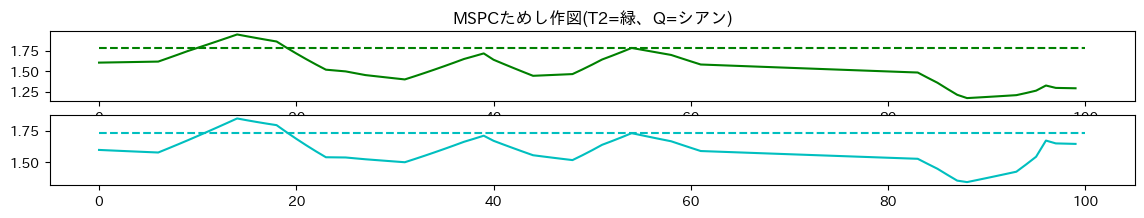

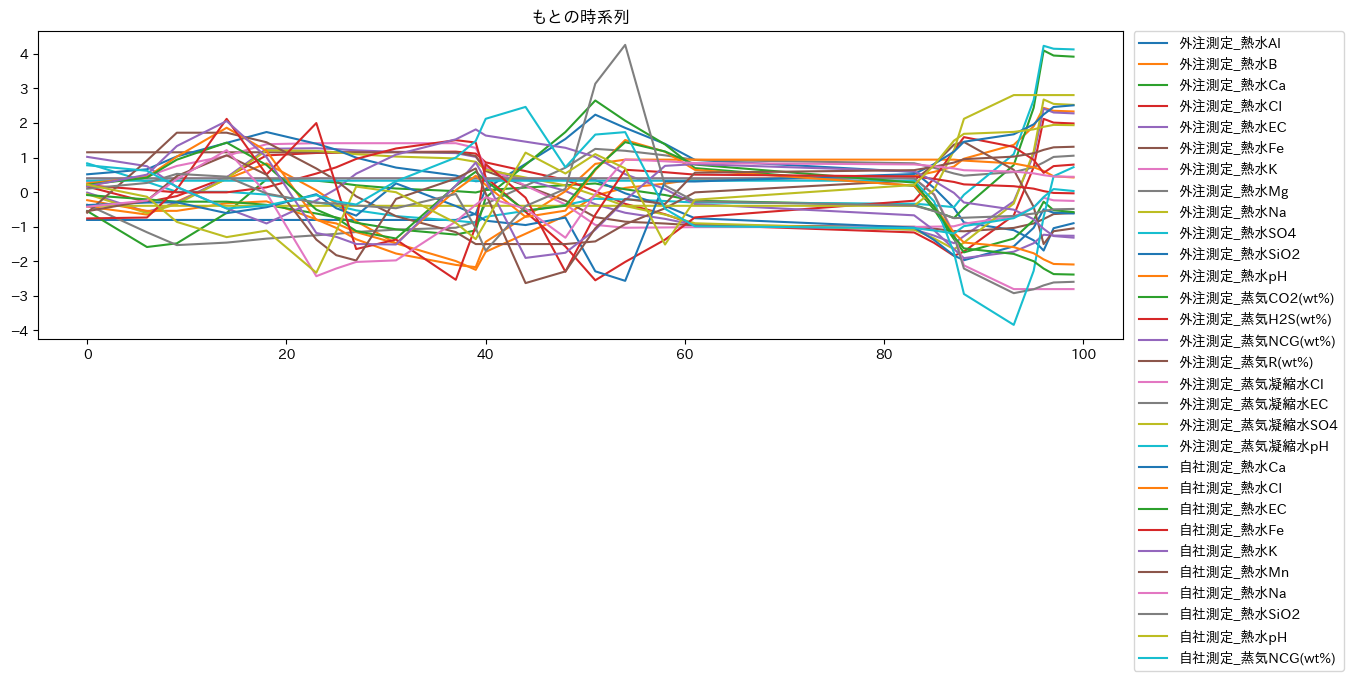

In [ ]:

##
## ------------------------ 6.8 MSPCでの異常検知------------------------
##

# 正常データを用いたモデルの学習
meanX, stdX, U, S, V = mspc_ref(df_scaled,
                                numPC = 2) # numPCは主成分の数。データの次元に合わせて変える必要。2次元に縮約。

# 異常度の計算
T2_train, Q_train = mspc_T2Q(df, meanX, stdX, U, S, V)

# 管理限界の取得
CL_T2,    CL_RE   = mspc_CL(T2_train, Q_train, df_scaled, alpha = 0.90)

# ためし図示
T2_train = T2_train / 10000 # 大きさ調整
CL_T2    = CL_T2 / 10000 # 大きさ調整

Q_train  = Q_train / 1e08 # 大きさ調整
CL_RE    = CL_RE / 1e08   # 大きさ調整

fig, axes = plt.subplots(2, 1, figsize=(14,2))
axes[0].title.set_text("MSPCためし作図(T2=緑、Q=シアン)")
axes[0].plot(range(0, len(T2_train)), abs(T2_train), color = "g") # 求めたT2スコア
axes[0].hlines( abs(CL_T2), 0, len(T2_train),
               color = "g", linestyle = 'dashed') # 管理限界CL_T2(点線)
axes[1].plot(range(0, len(Q_train)), abs(Q_train), color = "c")   # 求めたQスコア
axes[1].hlines( abs(CL_RE), 0, len(Q_train),
               color = "c", linestyle = 'dashed') # 管理限界CL_RE(点線)

df_scaled.plot(figsize=(14,4))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title("もとの時系列")

plt.show() # 異常個所が、各変数があばれている個所とだいたい一致しているもよう。

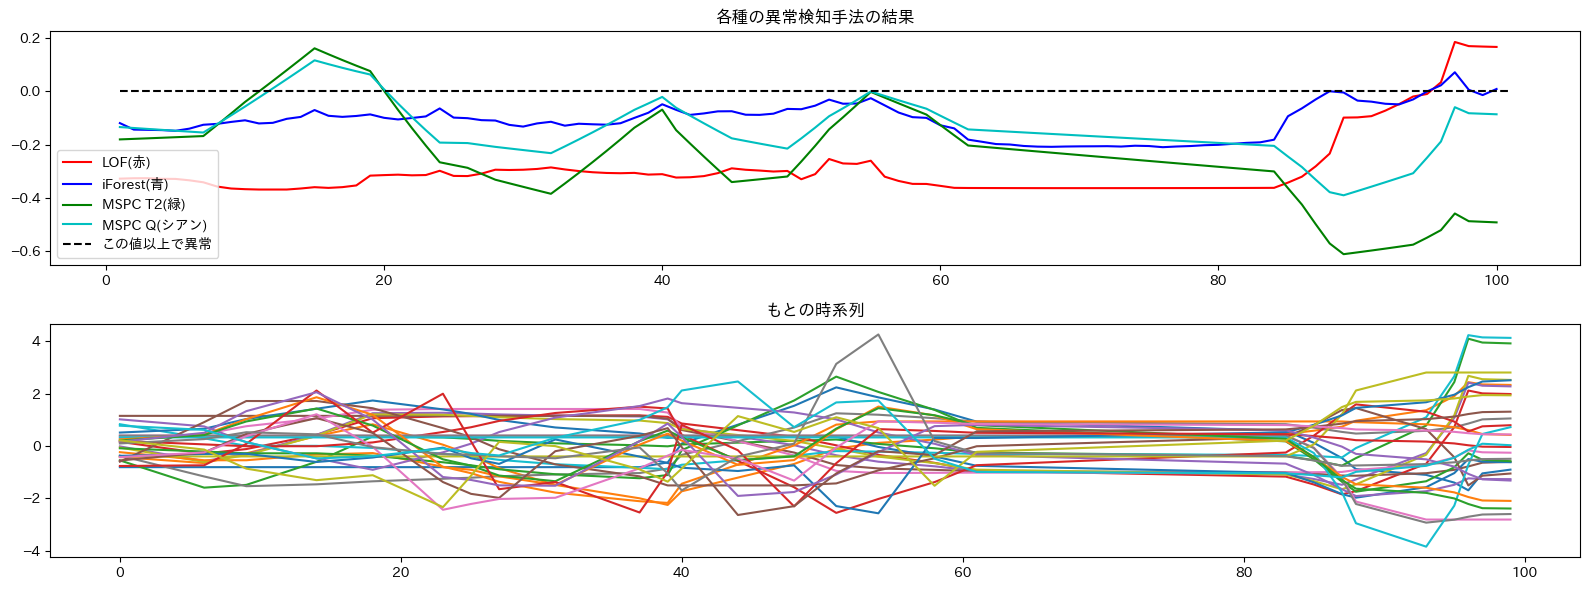

In [ ]:

##
## ------------------------ 6.15 異常検知結果の一括プロット（元データも） ------------------------
##

#
# --- 準備
#

# ヨコ軸の範囲を取得
yoko = df_scaled.shape[0] + 1

# 図のサイズを指定
fig, axes = plt.subplots(2, 1, tight_layout=True, figsize = (16,6))

#
# --- 異常度の値を表示
#

# LOF(赤)
axes[0].plot(list(range(1, yoko)), abs(score_lof)-abs(CL_lof),"r", label="LOF(赤)")
# iForest(青)
axes[0].plot(list(range(1, yoko)), abs(score_if)-abs(CL_if), "b", label="iForest(青)")
# MSPC T2(緑)
axes[0].plot(list(range(1, yoko)), abs(T2_train)-abs(CL_T2), "g", label="MSPC T2(緑)")
# MSPC Q(シアン))
axes[0].plot(list(range(1, yoko)), abs(Q_train)-abs(CL_RE), "c", label="MSPC Q(シアン)")
# ゼロ以上で異常
axes[0].hlines(0,       1, yoko,                            "k", label="この値以上で異常", linestyles = 'dashed') # 黒点線以上で異常

axes[0].legend(loc='best')
axes[0].set_title("各種の異常検知手法の結果")

#
# --- もとのデータと比較
#

axes[1].plot(df_scaled.index, df_scaled.values)
axes[1].set_title("もとの時系列")
fig.savefig(file+"_2.png")
plt.show()


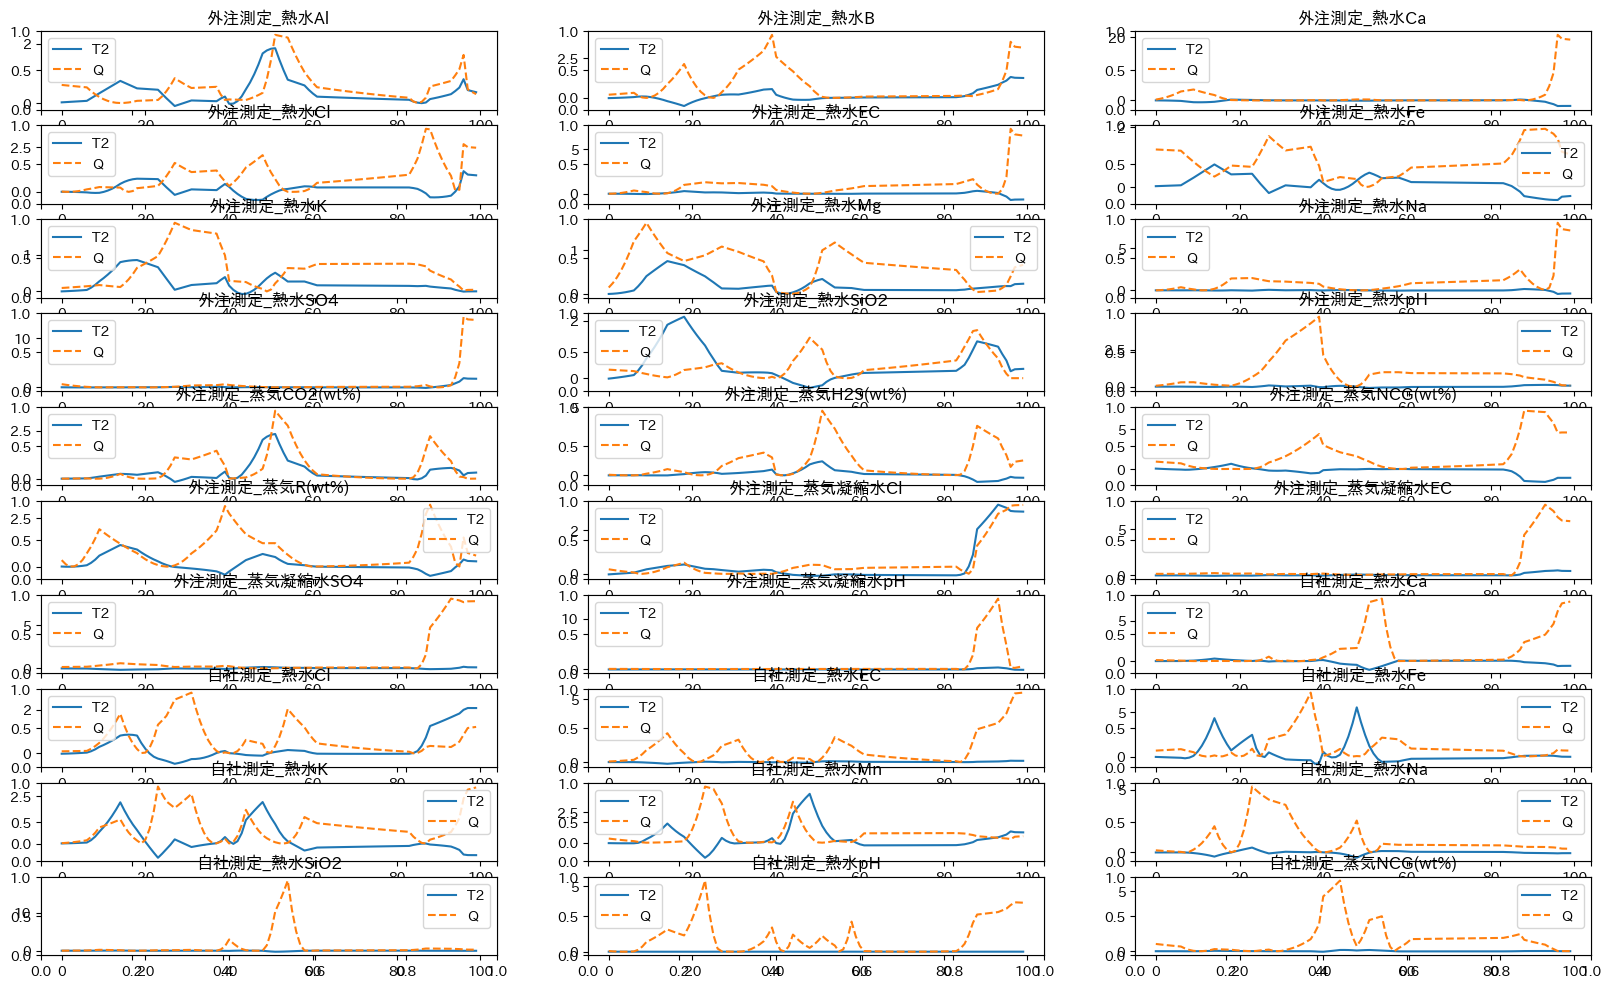

In [ ]:

##
## ------------------------ 6.16 寄与プロットによる異常診断------------------------
##

# 各変数、各時点 の 各寄与(T2, Q)の計算
cont_T2, cont_Q = cont_T2Q(
    np.array(df_scaled),
    np.array(meanX),
    np.array(stdX),
    U, S, V)

cont_T2_df = pd.DataFrame(cont_T2,
                          columns = df.columns)
cont_Q_df  = pd.DataFrame(cont_Q,
                          columns = df.columns)

# ためし作図
fig, ax = plt.subplots(10,3, sharex = True, sharey = False, figsize = (20, 12) )
for i in range(1,31):
  z = df.columns[i-1]
  ax = fig.add_subplot(10,3,i)
  ax.plot(cont_T2_df[z]*10, label = "T2") # *10は大きさ調整
  ax.plot(cont_Q_df[z],     label = "Q", linestyle = "dashed",  )
  ax.set_title(z, position=(0.5, 0.6))
  ax.legend(loc='best')
  ax.set_xticks([0,20,40,60,80,100])
  ax.set_xticklabels([0,20,40,60,80,100])

plt.show() # T2が寄与している時間帯と、Ｑが寄与している時間帯が、変数によって異なる様子がわかる。


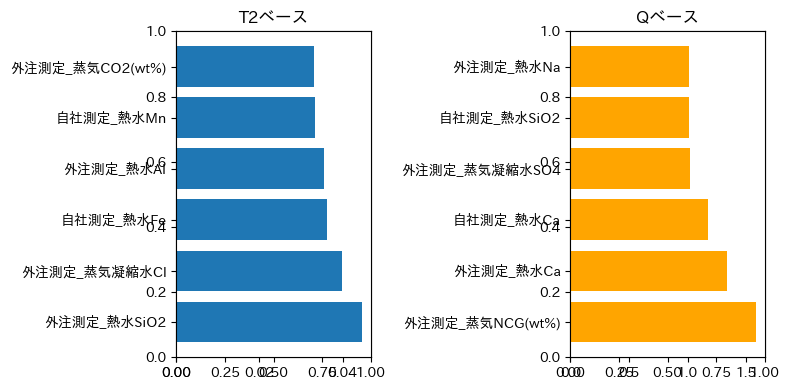

In [ ]:
#
# ---- 時刻 0 ～ 100(=yoko) の寄与の平均を計算 (本来 0～yoko でなく、異常度が高くなっている期間を抽出して代入。ここではとりあえず0)
#
fault_cont_T2 = np.average(cont_T2[0:yoko, :], axis = 0)
fault_cont_Q  = np.average( cont_Q[0:yoko, :], axis = 0)

#
# ---- 寄与の上位6番目までを求めて、プロット
#

#  T2ベースの上位６番目
fault_cont_T2_ser = pd.Series(fault_cont_T2, index = meanX.index).sort_values(ascending = False).iloc[0:6]
#  Qベースの上位６番目
fault_cont_Q_ser  = pd.Series(fault_cont_Q,  index = meanX.index).sort_values(ascending = False).iloc[0:6]
fig, ax = plt.subplots(1,2, sharex = True, sharey = False, figsize = (8, 4), tight_layout = True )

#  プロット
ax = fig.add_subplot(1,2,1)
ax.barh(fault_cont_T2_ser.index, fault_cont_T2_ser)
ax.set_title("T2ベース")

ax = fig.add_subplot(1,2,2)
ax.barh(fault_cont_Q_ser.index, fault_cont_Q_ser, color = "orange")
ax.set_title("Qベース")
fig.savefig(file+"_T2_Q2.png")
plt.show()